## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists to help out their decision makings.  
For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
#Import libralies

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

In [2]:
# Read the database
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [3]:
# Size of the dataset
df.shape

(294478, 5)

In [4]:
# The number of unique users
df['user_id'].nunique()

290584

In [5]:
# The propotion of users made conversions (conversion rate)
df['converted'].mean()

0.11965919355605512

In [6]:
# Control group goes old_page, treatment group goes new_page. 
# Check outliers
len(df.query('group == "treatment" & landing_page == "old_page"')) + len(df.query('group == "control" & landing_page == "new_page"'))

3893

In [7]:
# Check missing values
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

In [8]:
# Check datatype, data counts are correct
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. I should remove that row in order to examine date accurately.

In [9]:
# Remove rows are not aligned 
# Create a new dataframe as df2
df2 = df.query('group == "control" & landing_page == "old_page" or group == "treatment" & landing_page == "new_page"')

In [10]:
# Double check all of the correct rows were removed 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [12]:
# Number of unique users 
df2['user_id'].nunique()

290584

In [13]:
# Check duplicates
sum(df2['user_id'].duplicated())

1

In [14]:
# There is one duplicate, let's see 
print(df2[df2['user_id'].duplicated()])

      user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [15]:
# Remove that duplicate row
df2.drop_duplicates(subset='user_id', keep="first", inplace=True)

C:\Users\bebop\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Overall conversion rate (probability of an indivisual converting regardless of the page they receive) 
df['converted'].mean()

0.11965919355605512

In [17]:
# Conversion rate of the control group
df2.query('group == "control"').converted.mean()

0.1203863045004612

In [18]:
# Conversion rate of the treatment group 
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

In [19]:
# Probability of an indivisual receive the new page (Check pages are viewed equally)
len(df2.query('landing_page == "new_page"')) / len(df2['landing_page'])

0.5000619442226688

### Is there sufficient evidence to say that the new treatment page leads to more conversions?

**The probability of conversion for the Treatment group is 0.1189, The Control group is 0.1203.There is no sufficient exidence to say that new treatment group page leads more conversions at this point.**

<a id='ab_test'></a>
### Part II - A/B Test

Let's make a null and an alternative hypothesis based on all the data provided with  Type I error rate of **5%** to run a A/B testing.

$$H_{0} : p_{new} \leq p_{old} $$ 
$$H_{1} : p_{new} > p_{old} $$

Under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **conversion rate**  regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **conversion rate** in **ab_data.csv** regardless of the page. <br><br>

I used a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Then I performed the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [20]:
# Under the null, P_new and P_old are equal
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [22]:
# Let's call datas have new_page on landing_page column are n_new
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

In [23]:
# Let's call datas have old_page on landing_page column are n_old
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

In [24]:
# Simulate n_new transactions with a convert rate of p_new under the null.
# Create "new_page_converted", store n_new data. 
np.random.seed(42)
new_page_converted = np.random.choice([0,1] , size = n_new , p = [p_new , 1-p_new])

In [25]:
# Simulate n_new transactions with a convert rate of p_old under the null.
# Create "old_page_converted", store n_old data. 
np.random.seed(42)
old_page_converted = np.random.choice([0,1] , size = n_old , p = [p_old , 1-p_old])

In [26]:
# Compute obserbed difference (obs_diff) by subtracting p_old from p_new
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

9.034776111582765e-06

In [27]:
# Simulate conversion rate calculation for p_new and p_old for 10000 times, store data in new(old)_converted_simulation
# Compute p_diffs 

new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
p_diffs.mean()

-4.8249886196978635e-06

In [28]:
# Plot histgram of p_diffs. Should be a normal distribution
p_diffs = np.array(p_diffs)

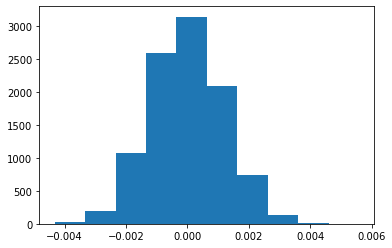

In [29]:
plt.hist(p_diffs);

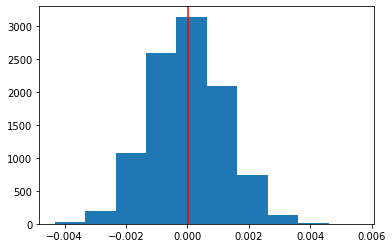

In [30]:
# Plot obs_diff on p-diff histogram.

plt.hist(p_diffs);
plt.axvline(x = obs_diff , color = 'red');

In [31]:
# Compute the p_value
# What propotion of the p_diffs are greater than the actual difference observed(obs_diff)?

p_value = (p_diffs > obs_diff).mean()
p_value

0.4921

Now I computed the p_value,which shows the probablilty of extreme results come up when null_hypothesis is True. P_values less than 0.05 are considered the defference is **statistically significant**. The p_value I calculated is greater than 0.05. I can say it is **not stastistically significant.** 
### It fail to reject the null hypothesis (I reject the new page).

### Alternatave approach: Z-model
As the other way to compute the difference, let's use a built-in to achieve similar results. Using the built-in might be easier to code, but the above portions are a major walkthrough of computing statistical significance. 

In [32]:
# I am going to use same data
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [33]:
# Import statsmodels api

import statsmodels.api as sm

# Prepare numbers of conversion and landing page data for old and new data
convert_old = len(df2.query('landing_page == "old_page" & converted == "1"'))
convert_new = len(df2.query('landing_page == "new_page" & converted == "1"'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

In [34]:
# Check results
print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17489
17264
145274
145310


In [35]:
# Use z test to compute the test statistic and p_value

z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

**The computed z-score is -1.31, and negative z-score reveals the alternative score is below the mean average. And the computed p_value is 0.905, greater than 0.05 again, that means it is not statistically  significant. There is no evidence to reject the null, both z-score and p-values I found agree with the finding in parts J and K.**

<a id='regression'></a>
### Part III - A regression approach

The result I acheived in the previous A/B test can also be acheived by performing regression.<br><br>

**I use Logistic Regression models since there are two outcomes(conversion or no-conversion), the responce will be non-quantitative responce but categorical responce and if there are only two possible outcomes,Logistic regression models would match in this dataset.** 

In [36]:
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [37]:
# Create a column for intercept
# Also create dummy variable column, which shows 1 when an individual receive the treatment page and 0 if control

df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

C:\Users\bebop\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\bebop\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [38]:
# Check column
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
# Use statsmodel to import the regression model. Fit the model using two columns I created before.

logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:20:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [40]:
# exponentiate the coefficirnt 
np.exp(-0.0150)

0.9851119396030626

**Conversions are 0.985 times as likely on new_pages than old_pages holding all else constant.**

**p-value is 0.19. It is different because:**

**In the part2, I use this hypothesis to see the mean conversion of new page is higher or not(Quantitive).
$$H_{0} : p_{new} \leq p_{old} $$ 
$$H_{1} : p_{new} > p_{old} $$**


**And for the regression model, I use this hypothesis to see new pages converts or not(Categorical).**
**$$H_{0} : p_{new} = p_{old} $$ 
$$H_{1} : p_{new} \neq p_{old} $$**

### Now, let's consider other things that might influence whether or not an individual converts.  

**It is good to consider other factors because I will be seeing higher probability of observing significant difference. Each individual have different mindset to reach conversions, it is better for us to examine conversion from multiple view.**

**There are several disadvantages,\
a: A linear relationships might not exist between responce and explanatory variables.\
b: I mught have correlated errors.\
c: I might not have constant variance of my errors.\
d: There might be outliers that hurt my model.\
e:significant bivariate relationships are not always significant in multiple regression model(Multicollinearity), and they results misleading results.**

**In order to fix these problems, I need to computing Variance Inflation Factors(VIFs) for each variables. If you see VIFs higher than 10,I would remove those variables.**
 
**It is important to check how I am going to use the data model, such as\
a; To see how X and y variables are related\
b: To predict the best responce variable\
c: To find which variables are useful in predicting the responce\
choose which variable I may need to use carefully!**

In [41]:
# Let's add an effect bsed on which country a user lives
# Read an additional dataset, merge the existing dataframe as df_new
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  
user_id                                 
834778           0          1        0  
928468           0          1        1  
822059           1          1        1  
711597           0          1        0  
710616           0          1        1

In [42]:
### Create the necessary dummy variables
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
# Drop CA(intercept does its job)
df_new[['CA', 'UK' , 'US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(['CA'], axis = 1)
df_new.head()

country                   timestamp      group landing_page  \
user_id                                                               
834778       UK  2017-01-14 23:08:43.304998    control     old_page   
928468       US  2017-01-23 14:44:16.387854  treatment     new_page   
822059       UK  2017-01-16 14:04:14.719771  treatment     new_page   
711597       UK  2017-01-22 03:14:24.763511    control     old_page   
710616       UK  2017-01-16 13:14:44.000513  treatment     new_page   

         converted  intercept  ab_page  UK  US  
user_id                                         
834778           0          1        0   1   0  
928468           0          1        1   0   1  
822059           1          1        1   1   0  
711597           0          1        0   1   0  
710616           0          1        1   1   0

In [44]:
# Though I have now looked at the individual factors of country and page on conversion, 
# I would now like to look at an interaction between page and country to see if there significant effects on conversion.
# Fit linear model and obtain the results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'US' , 'UK']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        23:20:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

In [45]:
# exponentiate the coefficirnt 
np.exp(0.0408) , np.exp(0.0507)

(1.0416437559600236, 1.052007243765014)

In [46]:
#Compute VIFs and drop columns if the score is higher than 10

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y,X = dmatrices('converted ~  US + UK', df_new, return_type = 'dataframe')

In [47]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X. values,i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

VIF Factor   features
0   20.041658  Intercept
1    4.502215         US
2    4.502215         UK

### VIFs are less than 10. I will not drop columns.

**☆RESULT**

**US: Compared to CA user, for every one user increase, conversions are 1.04 times as likely**

**UK: Compared to CA user, for every one user increase, conversions are 1.05 times as likely**

### Now let's take a look at if there is any influence associated with time.

In [48]:
# Change tatatype
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

In [49]:
# Ectract date, change datatype
df_new['date'] = df_new['timestamp'].dt.date

In [50]:
df_new['date'] = pd.to_datetime(df_new['date'])

In [51]:
# Create a column to check if it's weekday or not
df_new['weekday'] = pd.to_datetime(df_new['date']).dt.dayofweek

In [52]:
df_new["weekday"] = (df_new["weekday"] < 5).astype(int)

In [53]:
df_new.head()

country                  timestamp      group landing_page  converted  \
user_id                                                                         
834778       UK 2017-01-14 23:08:43.304998    control     old_page          0   
928468       US 2017-01-23 14:44:16.387854  treatment     new_page          0   
822059       UK 2017-01-16 14:04:14.719771  treatment     new_page          1   
711597       UK 2017-01-22 03:14:24.763511    control     old_page          0   
710616       UK 2017-01-16 13:14:44.000513  treatment     new_page          0   

         intercept  ab_page  UK  US       date  weekday  
user_id                                                  
834778           1        0   1   0 2017-01-14        0  
928468           1        1   0   1 2017-01-23        1  
822059           1        1   1   0 2017-01-16        1  
711597           1        0   1   0 2017-01-22        0  
710616           1        1   1   0 2017-01-16        1

In [54]:
### Fit Linear Model And Obtain the Results
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'weekday']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 15 Jul 2020   Pseudo R-squ.:               8.088e-06
Time:                        23:20:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.4230
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9883      0.012   -161.575      0.000      -2.012      -1.964
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
weekday       -0.0006      0.013     -0.049      0.961      -0.026       0.024
==============================================================================
"""

In [55]:
np.exp(0.0006)

1.0006001800360054

**☆RESULT**

**On weekdays, the chance of conversions are 1.0006 times more likely than on weekends holding all variables constant.**

<a id='conclusions'></a>
## Conclusions

①After cleaning the data, I computed the probability of conversion for the Treatment group is 0.1189, The Control group is 0.1203.I found there is no sufficient exidence to say that new treatment group page leads more conversions.

②I set a hypothesys test to see that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.
$$H_{0} : p_{new} \leq p_{old} $$ 
$$H_{1} : p_{new} > p_{old} $$
I performed the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.I computed p_value.It shows the probablilty when null_hypothesis is True,what percentage of extreme results come up. P_values less than 0.05 are considered the defference is statistically significant. The p_value I calculated was greater than 0.05. I can say it is not stastistically significant. It fail to reject the null hypothesis (I reject the new page).
I also computed z-score, that was -1.31, and negative z-score reveals the alternative score was below the mean average. And I computed p_value in a different method, that was 0.905, greater than 0.05 again, that means not statistically  significant. There is no evidence to reject the null.

③I used Logistic Regression models since there are two outcomes(conversion or no-conversion).I found conversions are 0.985 times as likely on new_pages than old_pages holding all else constant.And p-value was 0.19. It is different because I used a different(Categorical) hupothesis to see new pages converts or not:
**$$H_{0} : p_{new} = p_{old} $$ 
$$H_{1} : p_{new} \neq p_{old} $$**
But still, p-value was higher than 0.05(Fail to reject the null).

I added country columns by joining different dataset to see effects based on which country a user lives.The result was:
US: Compared to CA user, for every one user increase, conversions are 1.04 times as likely
UK: Compared to CA user, for every one user increase, conversions are 1.05 times as likely
I checked VIFs to prevent Multicollinearities and I did not drop any columns because VIF scores were all less than 10.

Lastly I added the influences associated with time on conversion.I created a column of "weekdays" to see if there is any conversion difference associated with time.By fitting a linear model, I obtained the result: On weekdays, the chance of conversions are 1.0006 times more likely than on weekends holding all variables constant.

As a result of ①～③, there is no sufficient exidence to say that new treatment group page leads more conversions(Fail to reject the null).And there is no effect based on which country a user lives, or time they access in order to ger higher conversions.